In [ ]:
# Clears all user-defined variables, functions, and imports without asking for confirmation.
%reset -f

# Initialization

## Import libaries

In [ ]:
import numpy as np
import pandas as pd
from numba import njit
import math
from scipy.signal import sawtooth

import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
import seaborn as sns

from aeon.utils.numba.general import z_normalise_series as aeon_z_normalise_series

# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.transformations.collection.Normalizer.html
from aeon.transformations.collection import Normalizer as aeon_Normalizer
from dtaidistance import (
    ed as dtai_ed,
    dtw as dtai_dtw,
    dtw_visualisation as dtai_dtw_visualisation,
)
from aeon.distances import (
    euclidean_distance as aeon_euclidean_distance,
    dtw_distance as aeon_dtw_distance,
    dtw_cost_matrix as aeon_dtw_cost_matrix,
)
from sktime.distances import dtw_distance as sktime_dtw_distance
from pyts.metrics import dtw as pyts_dtw
from tslearn.metrics import (
    dtw as tslearn_dtw,
    dtw_path as tslearn_dtw_path,
    lb_envelope as tslearn_lb_envelope,
    lb_keogh as tslearn_lb_keogh,
)
from dtw import dtw as dtw_dtw

from ksfdtw.utils import nearest_neighbor_interpolation
from ksfdtw.distance_measures import (
    usdtw_prime as usdtw_prime,
    usdtw as usdtw,
    psdtw_prime_vanilla as psdtw_prime_vanilla,
    psdtw_prime_lb_shen as psdtw_prime_lb_shen,
    euclidean_distance as euclidean_distance,
    dtw as dtw,
)
from ksfdtw.lower_bounds import (
    lb_kim,
    lb_kim_fl,
    lb_keogh_envelope,
    lb_keogh,
    lb_keogh_envelope_njit,
    lb_keogh_njit,
    lb_shen,
    lb_shen_njit,
)

import timeit
import time

import warnings

warnings.filterwarnings("ignore")

## Time series examples

In [4]:
np.random.seed(42)
Q = np.random.random(150)
C = np.random.random(150)
print(Q.shape, C.shape)

(150,) (150,)


# Normalization

In [31]:
Q_norm = aeon_z_normalise_series(Q)
print(Q_norm.mean(), Q_norm.std())  # ~0, ~1

-1.6579330501069005e-16 1.0000000000000002


In [33]:
normaliser = aeon_Normalizer()
Q_norm = normaliser.fit_transform(Q.reshape(1, -1))
Q_norm
Q_norm_mean = np.mean(Q_norm, axis=-1)
Q_norm_std = np.std(Q_norm, axis=-1)
print(Q_norm_mean, Q_norm_std)  # ~0, ~1
assert np.allclose(Q_norm_mean, 0)
assert np.allclose(Q_norm_std, 1)

[[-1.65793305e-16]] [[1.]]


In [ ]:
# Data from https://jmotif.github.io/sax-vsm_site/morea/algorithm/znorm.html
q = [
    2.02,
    2.33,
    2.99,
    6.85,
    9.20,
    8.80,
    7.50,
    6.00,
    5.85,
    3.85,
    4.85,
    3.85,
    2.22,
    1.45,
    1.34,
]
q = np.array(q)
q = pd.Series(q)

c = [
    -0.12,
    -0.16,
    -0.13,
    0.28,
    0.37,
    0.39,
    0.18,
    0.09,
    0.15,
    -0.06,
    0.06,
    -0.07,
    -0.13,
    -0.18,
    -0.26,
]
c = np.array(c)
c = pd.Series(c)

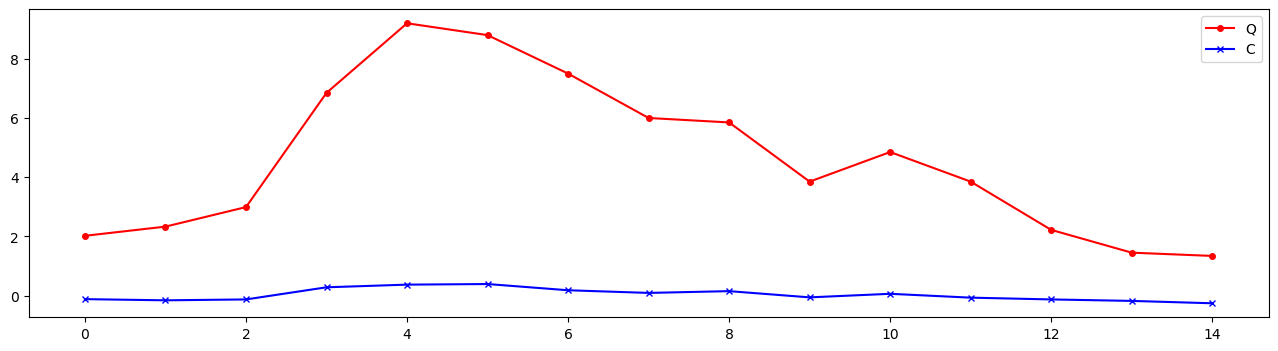

In [49]:
fig, ax = plot_series(
    q, c, markers=["o", "x"], colors=["red", "blue"], labels=["Q", "C"]
)

In [50]:
# A simple Z-normalization function
def normalize(ts):
    mean = np.mean(ts)
    std = np.std(ts)
    return (ts - mean) / std

Standard Z-normalizer from library

z_normalize only works for `series` but not `np array`.

In [53]:
q_znorm = normalize(q)
c_znorm = normalize(c)

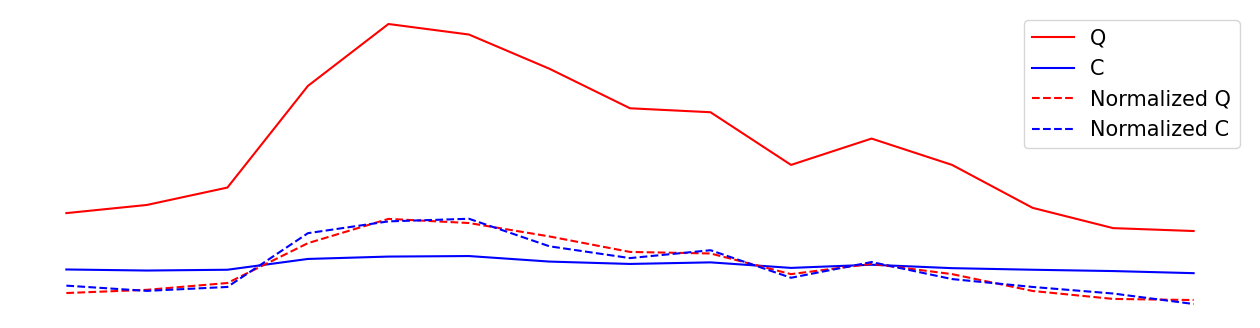

In [54]:
fig, ax = plot_series(
    q,
    c,
    q_znorm,
    c_znorm,
    markers=[None, None, None, None],
    colors=["red", "blue", "red", "blue"],
    labels=["Q", "C", "Normalized Q", "Normalized C"],
)
# fig, ax = plot_series(q, c, q_znorm, c_znorm, markers=["o", "x", "o", "x"], colors=["red", "blue", "red", "blue"], labels=["Q", "C", "Normalized Q", "Normalized C"]) fig, ax = plot_series(q, c, q_znorm, c_znorm, colors=["red", "blue", "red", "blue"], labels=["Q", "C", "Normalized Q", "Normalized C"])
ax.lines[2].set_linestyle("--")  # Dashed line for the first series
ax.lines[3].set_linestyle(("--"))  # Dotted line for the second series
# https://stackoverflow.com/questions/51054529/manipulate-linestyle-in-matplotlib-legend
plt.axis("off")
ax.legend(fontsize=15)
plt.savefig("../figures/normalization.pdf", format="pdf", bbox_inches="tight")
plt.show()

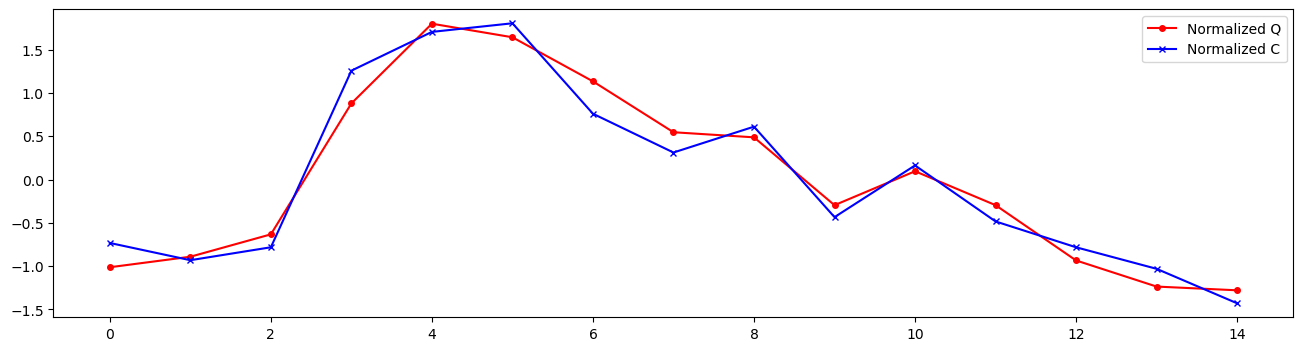

In [55]:
fig, ax = plot_series(
    q_znorm,
    c_znorm,
    markers=["o", "x"],
    colors=["red", "blue"],
    labels=["Normalized Q", "Normalized C"],
)
# https://stackoverflow.com/questions/51054529/manipulate-linestyle-in-matplotlib-legend
ax.legend()
plt.show()

# Interpolation

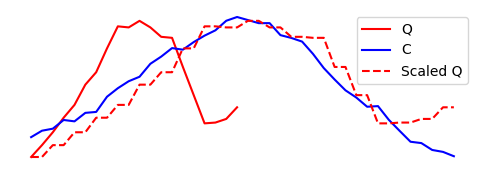

In [90]:
np.random.seed(0)
Q = np.cumsum(np.random.rand(20) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 20)))
C = np.cumsum(np.random.rand(40) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 40)))
Q_scaled = nearest_neighbor_interpolation(Q, len(C))

Q = aeon_z_normalise_series(Q)
C = aeon_z_normalise_series(C)
Q_scaled = aeon_z_normalise_series(Q_scaled)

fig, ax1 = plt.subplots(figsize=(6, 2))
ax1.plot(Q, label="Q", color="red")
ax1.plot(C, label="C", color="blue")
ax1.plot(Q_scaled, label="Scaled Q", linestyle="--", color="red")
ax1.legend()
# https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
plt.axis("off")
# https://www.tutorialspoint.com/save-the-plots-into-a-pdf-in-matplotlib
# plt.savefig("../figures/us.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Distance Measures

## ED

In [66]:
np.random.seed(42)
Q = np.random.random(20)
C = np.random.random(20)

0.9681751552406113
0.9681751552406113


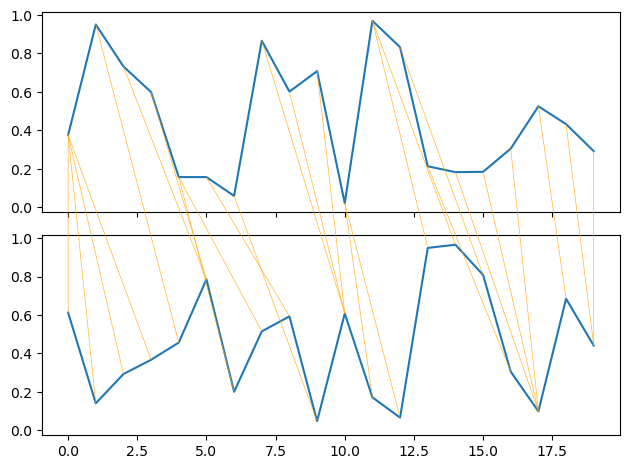

In [54]:
print(dtai_dtw.distance(Q, C, window=4))

path = dtai_dtw.warping_path(Q, C, window=4)
dtai_dtw_visualisation.plot_warping(Q, C, path)

# Test whether the local function is ED
dist = 0
for i in range(0, len(path)):
    dist += (Q[path[i][0]] - C[path[i][1]]) ** 2
print(np.sqrt(dist))
# The local function is indeed ED.

In [74]:
print(dtai_ed.distance(Q, C))
print(aeon_euclidean_distance(Q, C))
dist = euclidean_distance(Q, C)
print(dist, math.sqrt(dist))
no_of_runs = 10
t_dtai_ed_distance = timeit.timeit(
    lambda: dtai_ed.distance(Q, C),
    number=no_of_runs,
)
t_aeon_euclidean_distance = timeit.timeit(
    lambda: aeon_euclidean_distance(Q, C),
    number=no_of_runs,
)
t_euclidean_distance = timeit.timeit(
    lambda: euclidean_distance(Q, C),
    number=no_of_runs,
)
t_dtai_ed_distance, t_aeon_euclidean_distance, t_euclidean_distance
# (Slow) dtai, aeon, euclidean_distance (Fast)

2.3275702573015664
2.3275702573015664
5.41758330267488 2.3275702573015664


(6.833299994468689e-05, 5.292007699608803e-06, 3.374996595084667e-06)

## DTW

In [95]:
dtai_dtw.distance_fast(Q, C, use_pruning=True), dtai_dtw.distance(Q, C)

(2.2092542447515657, 2.2092542447515657)

In [107]:
(dist := aeon_dtw_distance(Q, C), math.sqrt(dist)), (
    dist := sktime_dtw_distance(Q, C),
    math.sqrt(dist),
)

((4.880804317952812, 2.2092542447515657),
 (4.880804317952812, 2.2092542447515657))

In [104]:
aeon_dtw_distance(Q, C, window=0.1), aeon_dtw_distance(Q, C, window=0.2), dtw(Q, C, 15)

(4.954591073485385, 4.880804317952812, 4.880804317952812)

In [108]:
pyts_dtw(Q, C)

/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2.2092542447515657

In [109]:
tslearn_dtw(Q, C), tslearn_dtw(
    Q, C, global_constraint="sakoe_chiba", sakoe_chiba_radius=2
)

(2.2092542447515657, 3.1303137560231056)

In [115]:
t_aeon_dtw_distance = timeit.timeit(
    lambda: aeon_dtw_distance(Q, C),
    number=no_of_runs,
)
t_aeon_dtw_distance_window_0_1 = timeit.timeit(
    lambda: aeon_dtw_distance(Q, C, window=0.1),
    number=no_of_runs,
)
t_sktime_dtw_distance = timeit.timeit(
    lambda: sktime_dtw_distance(Q, C),
    number=no_of_runs,
)
t_dtai_dtw_distance = timeit.timeit(
    lambda: dtai_dtw.distance(Q, C),
    number=no_of_runs,
)
t_dtai_dtw_distance_fast = timeit.timeit(
    lambda: dtai_dtw.distance_fast(Q, C, use_pruning=True),
    number=no_of_runs,
)
t_pyts_dtw_distance = timeit.timeit(
    lambda: pyts_dtw(Q, C),
    number=no_of_runs,
)
t_tslearn_dtw_distance = timeit.timeit(
    lambda: tslearn_dtw(Q, C),
    number=no_of_runs,
)
t_dtw_window_15 = timeit.timeit(
    lambda: dtw(Q, C, window=15),
    number=no_of_runs,
)
print(
    t_aeon_dtw_distance,
    t_aeon_dtw_distance_window_0_1,
    t_sktime_dtw_distance,
    t_dtai_dtw_distance,
    t_dtai_dtw_distance_fast,
    t_pyts_dtw_distance,
    t_tslearn_dtw_distance,
    t_dtw_window_15,
)
# (Slow) sktime, dtai (normal), pyts, tslearn, dtai (C), aeon (Fast)

0.002151917084120214 0.0005655839340761304 0.07158133399207145 0.16111133294180036 0.0014254170237109065 0.0033027500612661242 0.0020150839118286967 0.0013983329990878701


### Cost Matrix

In [117]:
distance, paths = dtai_dtw.warping_paths_fast(
    Q[:15],
    C[:15],
    # window=3+1
)
best_path = dtai_dtw.best_path(paths)
print(distance)
print(len(Q[:15]), len(C[:15]))
print(paths)
print(best_path)

1.0296815023560584
15 15
[[0.                inf        inf        inf        inf        inf
         inf        inf        inf        inf        inf        inf
         inf        inf        inf        inf]
 [       inf 0.53372577 0.55052912 0.59650587 0.6074736  0.8616728
  0.87179828 0.92119232 0.9992126  1.00854754 1.06876331 1.06878467
  1.09942887 1.12952178 1.14097153 1.1758462 ]
 [       inf 0.53541112 0.88915744 0.97592381 0.75404341 0.60847737
  0.93404622 0.91522586 0.93455614 1.17553122 1.03279886 1.18595204
  1.11520609 1.14426828 1.20332636 1.42903688]
 [       inf 0.56368152 0.72742999 0.93479394 0.79209071 0.65923162
  0.78120715 0.78349705 0.78405696 0.92689458 0.92690228 0.99589023
  1.00086716 1.0056989  1.02466203 1.20901469]
 [       inf 0.64311244 0.66834664 0.80782959 0.79958338 0.76442731
  0.74950129 0.75309432 0.7705241  0.85090746 0.86071409 0.89114094
  0.89177594 0.89245746 0.89467016 1.02901577]
 [       inf 0.98968153 0.64851606 0.64861145 0.7292977  1.10

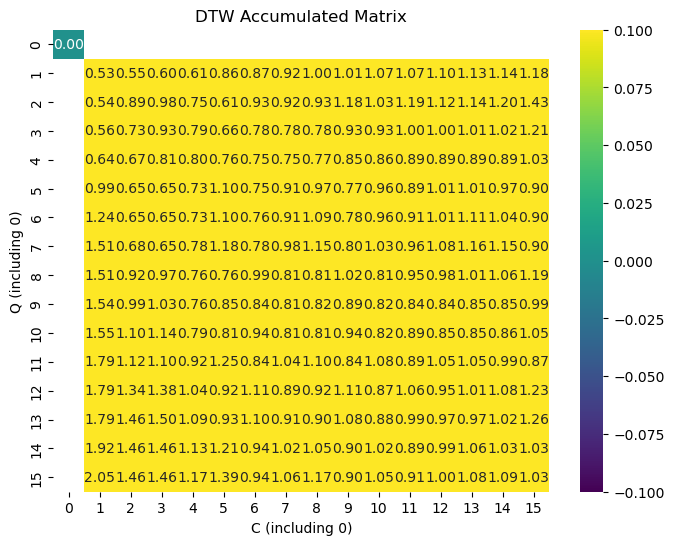

In [120]:
plt.figure(figsize=(8, 6))
sns.heatmap(paths, annot=True, fmt=".2f", cmap="viridis")
plt.title("DTW Accumulated Matrix")
plt.xlabel("C (including 0)")
plt.ylabel("Q (including 0)")
plt.show()

(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

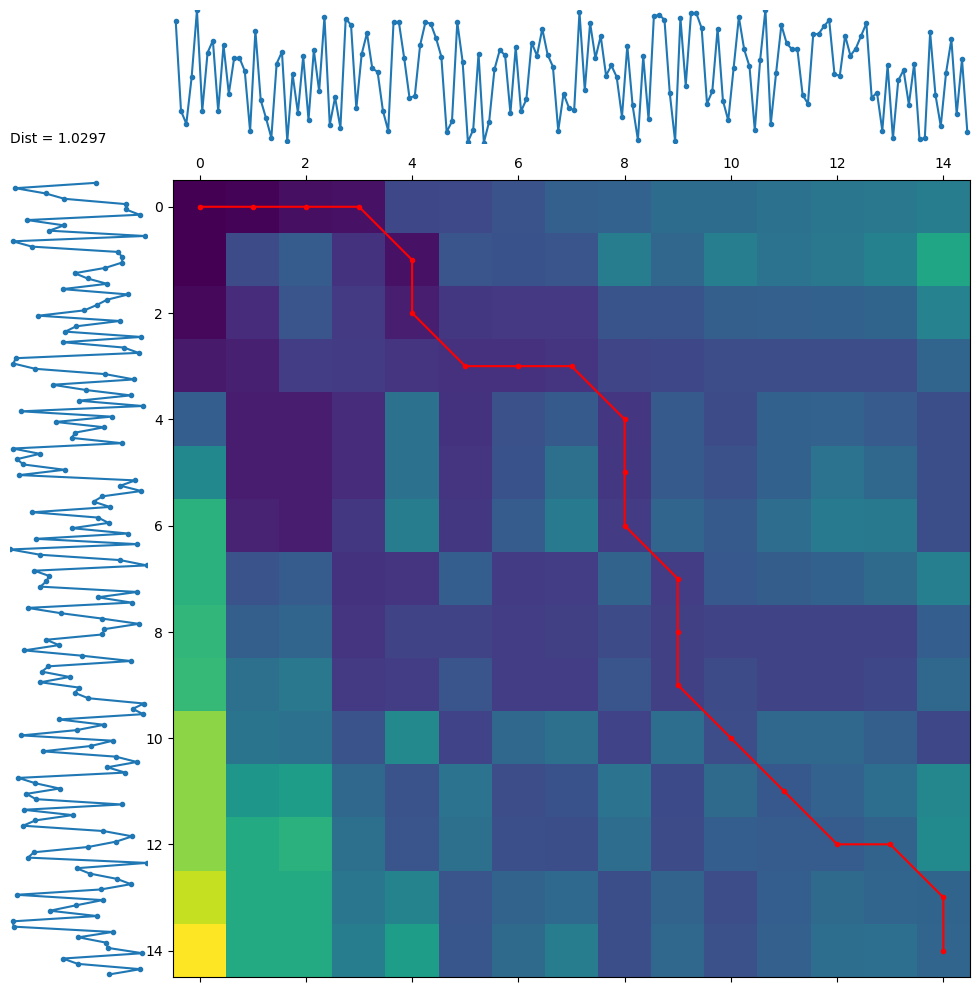

In [121]:
dtai_dtw_visualisation.plot_warpingpaths(Q, C, paths, best_path)

In [122]:
dist, mat = pyts_dtw(
    Q[:15],
    C[:15],
    method="sakoechiba",
    options={"window_size": 2},
    return_accumulated=True,
)
dist, mat

(1.169038139064468,
 array([[0.28486319, 0.30308232, 0.35581926,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf],
        [0.28666506, 0.79060095, 0.95242728, 0.56858147,        inf,
                inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf],
        [0.31773686, 0.52915439, 0.87383971, 0.62740769, 0.6329231 ,
                inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf],
        [       inf, 0.44668722, 0.65258864, 0.63933358, 0.77717048,
         0.76008895,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf],
        [       inf,        inf, 0.44681096, 0.55798928, 1.24627822,
         0.76749125, 1.02646561,        inf,        inf,        inf,
          

In [123]:
tslearn_dtw(Q[:15], C[:15], global_constraint="sakoe_chiba", sakoe_chiba_radius=2)

1.169038139064468

In [124]:
aeon_dtw_cost_matrix(Q[:15], C[:15], window=0.1)

array([[0.28486319, 0.30308232,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [0.28666506, 0.79060095, 0.95242728,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf, 0.52915439, 0.87383971, 0.93266593,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf,        inf, 0.7350558 , 0.74698169, 0.89674448,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf,        inf,        inf, 0.84623412, 1.43527064,
        0.90414678,        inf,        inf,        inf,        inf,
               inf,        inf,        inf, 

Time series shape: (100,)
First 10 values: [0.         0.12659245 0.25114799 0.37166246 0.48619674 0.59290793
 0.69007901 0.77614646 0.84972543 0.909632  ]


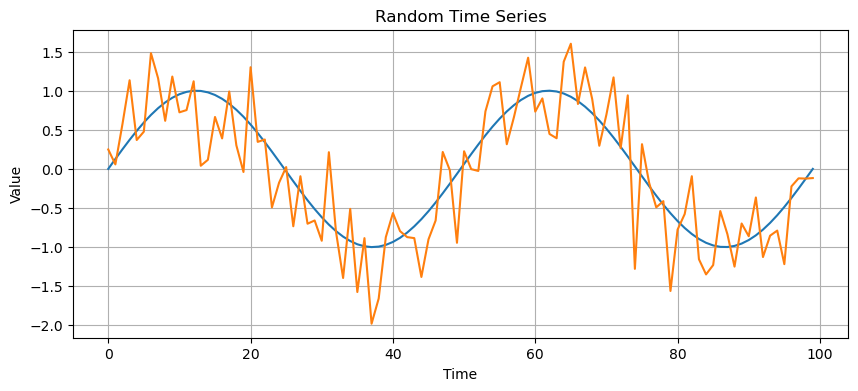

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate a random time series
length = 100  # Number of time points
# time_series = np.random.randn(length)

# Optional: Add a trend or pattern
# time_series = np.random.randn(length) + 0.1 * np.arange(length)  # With trend
Q = np.sin(np.linspace(0, 4 * np.pi, length))
C = np.sin(np.linspace(0, 4 * np.pi, length)) + 0.5 * np.random.randn(
    length
)  # Sinusoidal with noise

print(f"Time series shape: {Q.shape}")
print(f"First 10 values: {Q[:10]}")

# Plot the time series
plt.figure(figsize=(10, 4))
plt.plot(Q)
plt.plot(C)
plt.title("Random Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [59]:
Q = np.array([0, 1, 0, -1, 0], dtype=float)
x_coarse = np.linspace(0, 2 * np.pi, len(Q))
x_fine = np.linspace(0, 2 * np.pi, 9)
C = np.sin(x_fine)

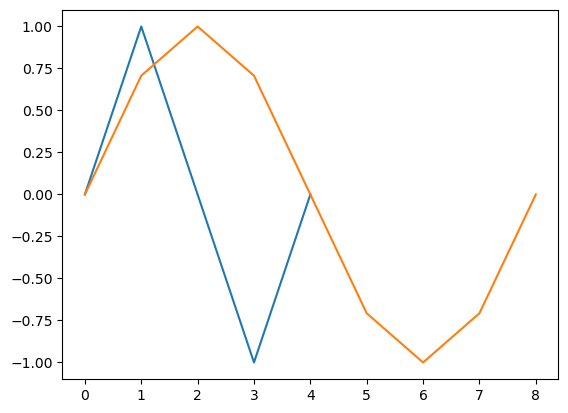

In [63]:
plt.plot(Q)
plt.plot(C)

In [65]:
# Must pass a distance function directly
manhattan = lambda x, y: np.abs(x - y)

alignment = dtw_dtw(
    Q.reshape(-1, 1),
    C.reshape(-1, 1),
    keep_internals=False,
    step_pattern="symmetric1",
    distance_only=False,
)

print("DTW distance:", alignment.distance)

DTW distance: 1.1715728752538102


## US

In [128]:
Q_x = np.linspace(0, 4 * np.pi, 70)
Q = np.sin(Q_x) * 50 + 50  # Scale to range around 0~100

C_x1 = np.linspace(0, 4 * np.pi, 100)
C_y1 = np.sin(C_x1) * 50 + 50  # Scale to range around 0~100
C_x2 = np.linspace(0, 1, 20)
C_y2 = np.piecewise(
    C_x2, [C_x2 < 0.5, C_x2 >= 0.5], [lambda x: 2 * x, lambda x: 2 * (1 - x)]
)
C_y2 = C_y2 * 50  # Scale it similarly
offset = C_y1[-1] - C_y2[0]
C_y2 = C_y2 + offset
C = np.concatenate([C_y1, C_y2])

In [131]:
len(Q), len(C)

(70, 120)

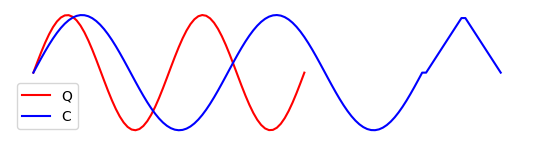

In [133]:
fig, ax1 = plt.subplots(figsize=(6, 2))
plt.plot(Q, color="red", label="Q")
plt.plot(C, color="blue", label="C")
# plt.title('C vs. Q')
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.axis("off")
# plt.savefig("../figures/us-prefix.pdf", format="pdf", bbox_inches="tight")
plt.show()

Simply performing dtw on Q and C returns a bad result.

In [134]:
C_prefix = C[:100]
C_prefix_scaled = nearest_neighbor_interpolation(C_prefix, len(Q))
len(C_prefix_scaled)

70

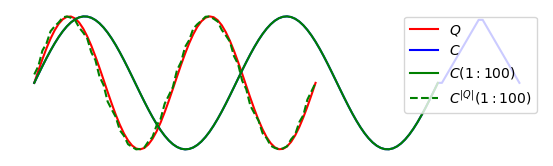

In [138]:
fig, ax1 = plt.subplots(figsize=(6, 2))
plt.plot(Q, color="red", label="$Q$")
plt.plot(C, color="blue", label="$C$")
plt.plot(C_prefix, color="green", label="$C(1:100)$")
plt.plot(C_prefix_scaled, linestyle="--", color="green", label="$C^{|Q|}(1:100)$")
plt.legend()
plt.tight_layout()
plt.axis("off")
plt.show()

As shown in the above graph, Q and scaled C(1:100) have a good match.

Test for USDTW. It select the most similar prefix $C(0:k)$ and compare it with $Q$.

In [140]:
l = 2  # scaling_factor
m = len(Q)
L = min(np.ceil(l * m), len(C))

best_so_far, best_k = usdtw(Q, C, l, L, 0.1, 0)
best_so_far, best_k, best_k / m  # best_k/m: best scaling factor
# k is the length of the prefix of C
# In this case, The prefix of C is longer than Q, about 1.42 times of the length of Q.

(684.8310384831086, 100, 1.4285714285714286)

## PSED, PSDTW

In [9]:
start_time = time.time()
print(psdtw_prime_vanilla(Q, C, 1.5, 3, 0.1, 0))
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")

(22.832826502193107, 337627, array([[  0,  42,   0,  58],
       [ 42,  89,  58, 104],
       [ 89, 150, 104, 150]]))
Execution time: 0.080091 seconds


In [14]:
P = 3
l = 1.5
m = len(Q)
l_root = math.sqrt(l)
L_avg = len(Q) / 3
L_max = min(int(math.floor(L_avg * l_root)), m)
L_max

61

In [20]:
(
    usdtw_prime(Q[0:42][::-1], C[0:58][::-1], L_max, 0.1, 0)
    + usdtw_prime(Q[42:89][::-1], C[58:104][::-1], L_max, 0.1, 0)
    + usdtw_prime(Q[89:150][::-1], C[104:150][::-1], L_max, 0.1, 0)
)

22.832826502193107

In [10]:
start_time = time.time()
print(psdtw_prime_lb_shen(Q, C, 1.5, 3, 0.1, 0))
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")

(22.832826502193107, 337435, array([[  0,  42,   0,  58],
       [ 42,  89,  58, 104],
       [ 89, 150, 104, 150]]))
Execution time: 0.117263 seconds


Create toy example for testing the idea of PSDTW.

In [ ]:
# Step 1: Create segments
def generate_segments():
    s1 = np.sin(np.linspace(0, 2 * np.pi, 20))  # 30
    # s1 = np.linspace(0, 1, 15)
    s2 = sawtooth(np.linspace(0, 2 * np.pi, 20), 0.5)  # Triangle wave (periodic) # 20
    # s2 = np.concatenate([np.ones(10), np.linspace(1, 0.5, 5)])
    s3 = np.tile([-1, 1], 20)
    tail = np.linspace(1, 0, 30)
    return s1, s2, s3, tail
    # return s1, s2, tail


# Step 3: Compose sequences
def create_series(with_tail=False):
    s1, s2, s3, tail = generate_segments()
    # s1, s2, tail = generate_segments()
    Q = np.concatenate([s1, s2, s1])
    # Q = np.concatenate([s1, s2])
    C = np.concatenate(
        [
            nearest_neighbor_interpolation(s1, int(len(s1) * 0.4)),
            nearest_neighbor_interpolation(s2, int(len(s2) * 1.8)),
            nearest_neighbor_interpolation(s1, int(len(s1) * 0.7)),
        ]
    )
    if with_tail:
        C = np.concatenate([C, tail])
    return Q, C


# Step 4: Plotting with ground truth segment boundaries
def plot_segmented_series(Q, C):
    plt.figure(figsize=(12, 5))
    plt.plot(Q, label="Q", color="red", linewidth=1)
    plt.plot(C, label="C", color="blue", linestyle="--", linewidth=1)

    # for idx in q_segments[1:-1]:  # skip 0 and end
    #     plt.axvline(idx, color='blue', linestyle='--', alpha=0.5)
    # for idx in c_segments[1:-1]:
    #     plt.axvline(idx, color='red', linestyle=':', alpha=0.5)

    # plt.title("Segmented Time Series with Expression Rate Difference + Tail")
    from matplotlib.ticker import MultipleLocator

    plt.gca().xaxis.set_major_locator(MultipleLocator(5))
    plt.legend()
    # plt.grid(True)
    # plt.xlabel("Time index")
    # plt.ylabel("Value")
    plt.show()

60 58


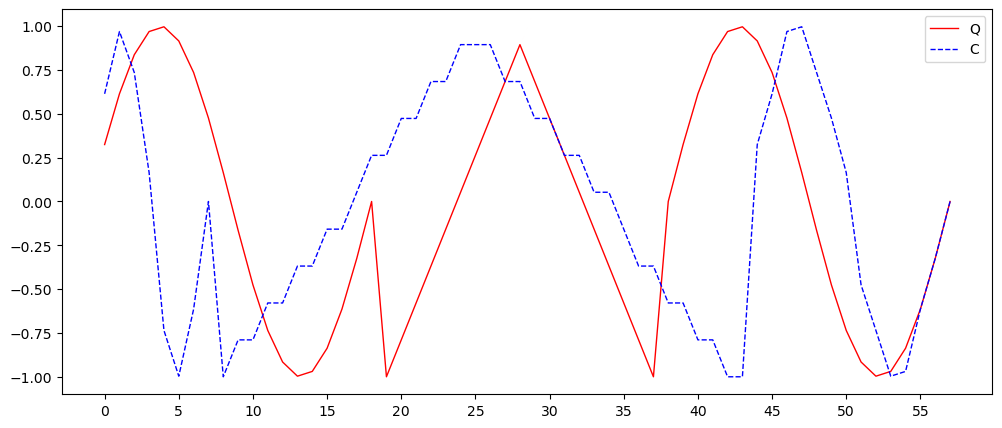

(58, 58)

In [35]:
Q, C = create_series(False)
print(len(Q), len(C))
Q = nearest_neighbor_interpolation(Q, min(len(Q), len(C)))
C = nearest_neighbor_interpolation(C, min(len(Q), len(C)))

# # Step 5: Ground truth (simulated for this synthetic case)
# q_segments = [0, 30, 60, 90]  # Original segments in Q
# c_segments = [0,
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)),
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)) +
#               len(scale_segment(np.ones(30), 1.3)),
#               len(C)]  # including tail

plot_segmented_series(Q, C)
len(Q), len(C)

In [38]:
psdtw_prime_vanilla(Q, C, 2, 3, 0.1, 0)

(10.858297955901303,
 39178,
 array([[ 0, 24,  0, 17],
        [24, 38, 17, 44],
        [38, 58, 44, 58]]))

# Lower bounds

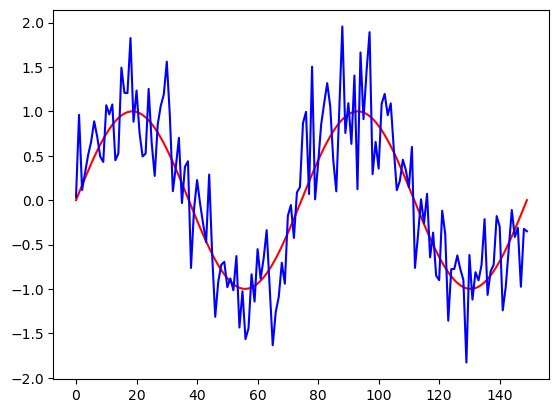

In [5]:
np.random.seed(18)
Q = np.sin(np.linspace(0, 4 * np.pi, 150))
C = Q + np.random.normal(0, 0.4, size=150)
plt.plot(Q, label="Q", color="red")
plt.plot(C, label="C", color="blue")

Check whether the results of DTW are consistent, especially for the definition of $r$.

In [6]:
r_float = 1 / 10
(dist := aeon_dtw_distance(Q, C, window=r_float), math.sqrt(dist))

(21.220144894375064, 4.606532849592529)

In [7]:
r_int = int(len(Q) * (r_float))
r_int

15

In [8]:
# The definition of the window here is slightly different, always + 1
dtai_dtw.distance(Q, C, window=1 + r_int)

4.606532849592529

In [9]:
tslearn_dtw(Q, C, global_constraint="sakoe_chiba", sakoe_chiba_radius=r_int)

4.606532849592529

In [10]:
dtw(Q, C, window=r_float)

21.220144894375064

The results are consistent!

### $LB_{Kim}$ and $LB_{KimFL}$

In [12]:
lb_kim(Q, C), lb_kim_fl(Q, C)

(0.9137770853153537, 0.12398967316885692)

### $LB_{Keogh}$

In [13]:
(lb := lb_keogh(Q, C, r_int), math.sqrt(lb))

(np.float64(6.660071204235693), 2.5807113756163615)

In [14]:
# Exchange Q and C
(lb := lb_keogh(C, Q, r_int), math.sqrt(lb))

(np.float64(0.014236616703276177), 0.11931729423380408)

In [15]:
(lb := lb_keogh_njit(Q, C, r_int), math.sqrt(lb))

(6.660071204235693, 2.5807113756163615)

In [16]:
# Exchange Q and C
(lb := lb_keogh_njit(C, Q, r_int), math.sqrt(lb))

(0.014236616703276177, 0.11931729423380408)

Test for $LB_{Keogh}$ from [tslearn](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.lb_keogh.html#tslearn.metrics.lb_keogh).

In [17]:
env_low, env_up = tslearn_lb_envelope(Q, radius=r_int)
res1 = tslearn_lb_keogh(ts_query=C, envelope_candidate=(env_low, env_up))
# Another way to write it
# We built the envelope of ts_candidate here.
res2 = tslearn_lb_keogh(ts_query=C, ts_candidate=Q, radius=r_int)
print(res1, res2)

2.580711375616361 2.580711375616361


The results are consistent!

Check envelope resulted between lb_keogh_envelope_slow() and lb_keogh_envelope().

lb_keogh_slow() calls lb_keogh_envelope_slow(). But lb_keogh() does not call lb_keogh_envelope().

In [18]:
res1 = lb_keogh_envelope(Q, r_int)
res2 = lb_keogh_envelope_njit(Q, r_int)
assert np.array_equal(res1, res2)
res1 = lb_keogh_envelope(C, r_int)
res2 = lb_keogh_envelope_njit(C, r_int)
assert np.array_equal(res1, res2)

### $LB_{Shen}^{DTW}$

In [24]:
lb_shen(Q, C, r_int, l=1), lb_shen_njit(Q, C, r_int, l=1)

(np.float64(6.825066903515484), 6.825066903515484)

In [25]:
# Exchange Q and C
lb_shen(C, Q, r_int, l=1), lb_shen_njit(C, Q, r_int, l=1)

(np.float64(0.26640674815655424), 0.26640674815655424)

$LB_{Shen}$ lower-bounds DTW.

$LB_{Shen} \geq LB_{Keogh}$.